In [129]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dhanush/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dhanush/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/dhanush/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [130]:
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sqlalchemy.orm import Session
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from utils.db_utils import DB_ENGINE, Item, Recipe, Restaurant

In [131]:
%time

# Preprocessing function
def preprocess(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    cleaned_text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens if word not in stop_words])
    return cleaned_text

# Get entrees and recipes from the database
with Session(DB_ENGINE) as session:
    entrees = session.query(Item).all()
    recipes = session.query(Recipe).all()
    print(f"Found {len(entrees)} entrees and {len(recipes)} recipes")

# Preprocess entree descriptions and recipe ingredients
entree_descriptions = [preprocess(entree.description) for entree in entrees]
recipe_ingredients = [preprocess(recipe.ingredients) for recipe in recipes]

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Vectorize the preprocessed text
entree_vectors = vectorizer.fit_transform(entree_descriptions)
recipe_vectors = vectorizer.transform(recipe_ingredients)

# Compute cosine similarity
similarity_matrix = cosine_similarity(entree_vectors, recipe_vectors)

# Assign vegetarian-friendly scores
vegetarian_friendly_scores = similarity_matrix.max(axis=1)


# Assign scores to entrees
with Session(DB_ENGINE) as session:
    for idx, entree in enumerate(entrees):
        entree.vegetarian_friendly_score = vegetarian_friendly_scores[idx]
    session.commit()

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.05 µs
Found 1924 entrees and 683 recipes


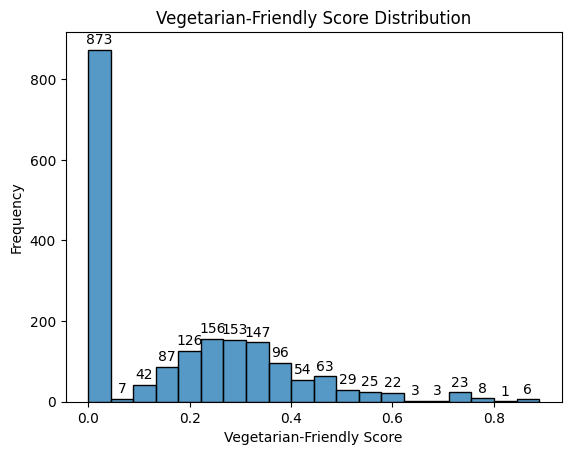

In [132]:
# Create a Seaborn distribution plot
n_bins = 20
hist_plot = sns.histplot(vegetarian_friendly_scores, kde=False, bins=n_bins)

# Set plot title and labels
plt.title('Vegetarian-Friendly Score Distribution')
plt.xlabel('Vegetarian-Friendly Score')
plt.ylabel('Frequency')

bin_heights, bin_edges, _ = hist_plot.hist(vegetarian_friendly_scores, bins=n_bins, alpha=0)
for i in range(n_bins):
    height = bin_heights[i]
    if height > 0:
        hist_plot.annotate(f'{int(height)}', xy=(bin_edges[i]+(bin_edges[i+1]-bin_edges[i])/2, height),
                           xycoords='data', xytext=(0, 2), textcoords='offset points',
                           fontsize=10, ha='center', va='bottom')


# Show the plot
plt.show()

In [133]:
# Print a few item names per bin
n_items_to_print = 3

bins = [[] for _ in range(n_bins)]

# Assign item names to the corresponding bins
for idx, score in enumerate(vegetarian_friendly_scores):
    bin_idx = min(np.digitize(score, bin_edges) - 1, len(bins) - 1)
    bins[bin_idx].append(entrees[idx].name)

# Print a few item names from each bin
for i, bin_items in enumerate(bins):
    print(f"Bin {i + 1} ({bin_edges[i]:.2f} to {bin_edges[i + 1]:.2f}):")
    for item_name in bin_items[:n_items_to_print]:
        print(f"  - {item_name}")
    print()

Bin 1 (0.00 to 0.04):
  - Bacon (4 Slices)
  - Sausage (4 Slices)
  - Ham Steak

Bin 2 (0.04 to 0.09):
  - Lumpia Shanghai
  - 100% Pure Maple Syrup
  - Crispy Pata

Bin 3 (0.09 to 0.13):
  - Magoo's 1/2 lb. Burger
  - Fruit Snowbubble
  - Honey Mango 100% Real Fruit

Bin 4 (0.13 to 0.18):
  - Chicken Jambalaya
  - Salmon Filet
  - Garlic Fried Rice

Bin 5 (0.18 to 0.22):
  - Turkey Bacon Melt
  - Tri-Tip Sandwich
  - Bacon Cheeseburger

Bin 6 (0.22 to 0.27):
  - Chicken Cobb Salad
  - Ruben Sandwich
  - Swiss Mushroom Burger

Bin 7 (0.27 to 0.31):
  - Meatloaf Sandwich
  - Magoo's Special CBB Burger
  - Patty Melt

Bin 8 (0.31 to 0.36):
  - Southwestern Chicken Salad
  - Buffalo Chicken Sandwich
  - Steak Sandwich

Bin 9 (0.36 to 0.40):
  - Kale Caesar Salad
  - BLT
  - Philly Cheese Steak

Bin 10 (0.40 to 0.44):
  - Monterey Chicken
  - Traditional Club
  - Spaghetti and Meatballs

Bin 11 (0.44 to 0.49):
  - Cheese Quesadilla
  - BBQ Chicken Salad
  - Grilled Ham and Cheese

Bin 12 (

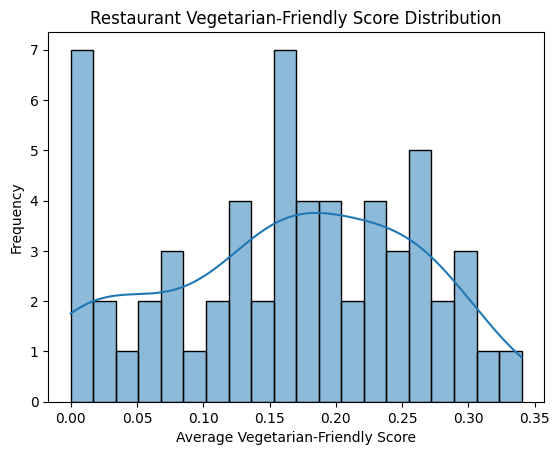

In [134]:
from collections import defaultdict

# Assuming you have a list of entrees with their scores and restaurant IDs
entrees_with_scores = [
    {
        "name": entree.name,
        "restaurant_id": entree.restaurant_id,
        "vegetarian_friendly_score": score
    }
    for entree, score in zip(entrees, vegetarian_friendly_scores)
]

# Calculate the average score for each restaurant
restaurant_scores = defaultdict(lambda: {"count": 0, "total_score": 0})

for entree in entrees_with_scores:
    restaurant_id = entree["restaurant_id"]
    restaurant_scores[restaurant_id]["count"] += 1
    restaurant_scores[restaurant_id]["total_score"] += entree["vegetarian_friendly_score"]

for restaurant_id, data in restaurant_scores.items():
    data["average_score"] = data["total_score"] / data["count"]

# Sort the restaurant scores in descending order
sorted_restaurant_scores = sorted(restaurant_scores.items(), key=lambda x: x[1]['average_score'], reverse=True)

# # Print the sorted scores
# for restaurant_id, data in sorted_restaurant_scores:
#     print(f"Restaurant ID {restaurant_id}: Average Vegetarian-Friendly Score = {data['average_score']:.2f}")

# Create a list of average scores for the histogram
average_scores = [data['average_score'] for _, data in sorted_restaurant_scores]

# Create a histogram of the restaurant score distribution
sns.histplot(average_scores, kde=True, bins=20)

# Set plot title and labels
plt.title('Restaurant Vegetarian-Friendly Score Distribution')
plt.xlabel('Average Vegetarian-Friendly Score')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [135]:
# Fetch the restaurant names from the database
with Session(DB_ENGINE) as session:
    restaurants = session.query(Restaurant).all()
restaurant_dict = {restaurant.id: restaurant.name for restaurant in restaurants}

# Create a list of average scores for the histogram
average_scores = [data['average_score'] for _, data in sorted_restaurant_scores]

# Assign restaurant names and scores to the corresponding bins
n_bins = 20
n_items_to_print = 3

bins = [[] for _ in range(n_bins)]
bin_edges = np.histogram_bin_edges(average_scores, bins=n_bins)

for restaurant_id, data in sorted_restaurant_scores:
    bin_idx = min(np.digitize(data["average_score"], bin_edges) - 1, len(bins) - 1)
    bins[bin_idx].append((restaurant_dict[restaurant_id], data["average_score"]))

# Print a few restaurant names and scores from each bin
for i, bin_items in enumerate(bins):
    print(f"Bin {i + 1} ({bin_edges[i]:.2f} to {bin_edges[i + 1]:.2f}):")
    for name, score in bin_items[:n_items_to_print]:
        print(f"  - {name} (score: {score:.2f})")
    print()

Bin 1 (0.00 to 0.02):
  - Edible Arrangements (1866 S Norfolk St ) (score: 0.02)
  - Crawstation (score: 0.01)
  - Brioche de Paris (score: 0.00)

Bin 2 (0.02 to 0.03):
  - Philhouse- Hayward (score: 0.02)
  - Kusinera (score: 0.02)

Bin 3 (0.03 to 0.05):
  - Elaine's Cajun Cuisine (score: 0.05)

Bin 4 (0.05 to 0.07):
  - Kendejah Restaurant (score: 0.06)
  - PhilHouse (score: 0.06)

Bin 5 (0.07 to 0.09):
  - Gyro Station (47 6th Street) (score: 0.08)
  - Oriental Food Market (score: 0.07)
  - KRISPY KRUNCHY CHICKEN (2353 East 12th Street) (score: 0.07)

Bin 6 (0.09 to 0.10):
  - GOL ICE CREAM (score: 0.09)

Bin 7 (0.10 to 0.12):
  - Flavas Jamaican Grill (score: 0.12)
  - Flavas Jamaican Grill (score: 0.11)

Bin 8 (0.12 to 0.14):
  - Afghan Burrito (score: 0.13)
  - Kolobok (the only Russian food truck in the Bay Area) (score: 0.13)
  - 77 Chinese & Vietnamese Cuisine (score: 0.13)

Bin 9 (0.14 to 0.15):
  - The Bussdown (score: 0.15)
  - JP cafe (score: 0.15)

Bin 10 (0.15 to 0.17):


In [136]:
# Save restaurant scores to the DB
with Session(DB_ENGINE) as session:
    for restaurant_id, data in sorted_restaurant_scores:
        restaurant = session.query(Restaurant).get(restaurant_id)
        restaurant.vegetarian_friendly_score = data["average_score"]
    session.commit()

In [139]:
# Get restaurant scores from the DB and sort by descending score
with Session(DB_ENGINE) as session:
    restaurants = session.query(Restaurant).all()
    sorted_restaurants = sorted(restaurants, key=lambda x: x.vegetarian_friendly_score if x.vegetarian_friendly_score is not None else -1, reverse=True)

# Print the sorted restaurant scores
for restaurant in sorted_restaurants:
    print(f"Restaurant ID {restaurant.id}: {restaurant.name} - Average Vegetarian-Friendly Score = {restaurant.vegetarian_friendly_score}")

Restaurant ID 89: Pizza Matador - Average Vegetarian-Friendly Score = 0.3401694362436312
Restaurant ID 186: The Kebab Shop (Walnut Creek) - Average Vegetarian-Friendly Score = 0.3139418659917889
Restaurant ID 245: Baltic Spice House - Average Vegetarian-Friendly Score = 0.29747805548636547
Restaurant ID 165: Halal 786 Degrees - Average Vegetarian-Friendly Score = 0.2962296690475517
Restaurant ID 164: Halal Grill - Average Vegetarian-Friendly Score = 0.28962480272452273
Restaurant ID 125: Fusion SF - Average Vegetarian-Friendly Score = 0.274378272786591
Restaurant ID 73: Honey Bar - Average Vegetarian-Friendly Score = 0.273224074198212
Restaurant ID 86: Brews&brats - Average Vegetarian-Friendly Score = 0.2677924705203346
Restaurant ID 257: Magoo's Grill - Average Vegetarian-Friendly Score = 0.26563109648276567
Restaurant ID 267: Badri's Biryani Bar - Average Vegetarian-Friendly Score = 0.2644832743976273
Restaurant ID 273: Tamari Authentic Georgian Cuisine - Average Vegetarian-Friendly 